## Challenge Description

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users written by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised because the test is negative. That is, it appears that the non-highly localized translation was doing better!

You are asked to:

* Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

* Explain why that might be happening. Are the localized translations really worse?

* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.

---

## Load Data

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [3]:
test.head(3)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0


In [4]:
user.head(3)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia


## EDA

In [5]:
# check the number of users in both tables
print(test.user_id.nunique())
print(user.user_id.nunique())
print('diff:',test.user_id.nunique()-user.user_id.nunique())

453321
452867
diff: 454


In [6]:
# check those diff users
diff = test[~test['user_id'].isin(user['user_id'])]
diff.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
819,657841,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0
1696,859340,2015-12-04,Direct,Mobile,EN,NaN,Android_App,0,0
1934,716487,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,0
2409,87209,2015-12-01,Direct,Web,ES,NaN,Chrome,0,0
2721,771642,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0


In [7]:
# the diff users has a higher conversion rate than the matched users
print(diff.conversion.value_counts())
print(diff.conversion.mean())
print(test.conversion.mean())

0    423
1     31
Name: conversion, dtype: int64
0.06828193832599119
0.04957855471067963


In [8]:
print(diff.test.value_counts())
print(test.test.value_counts())

0    245
1    209
Name: test, dtype: int64
0    237338
1    215983
Name: test, dtype: int64


In [10]:
import cufflinks as cf
cf.go_offline()

In [12]:
# check the duration of the experiment
print(test['date'].max())
print(test['date'].min())

2015-12-04
2015-11-30


In [13]:
# join two tables
data = pd.merge(test, user, on='user_id')
data.head(3)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain


In [14]:
data.describe()
# conversion rate is about 4.96%

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 452867 entries, 0 to 452866
Data columns (total 12 columns):
user_id             452867 non-null int64
date                452867 non-null object
source              452867 non-null object
device              452867 non-null object
browser_language    452867 non-null object
ads_channel         181693 non-null object
browser             452867 non-null object
conversion          452867 non-null int64
test                452867 non-null int64
sex                 452867 non-null object
age                 452867 non-null int64
country             452867 non-null object
dtypes: int64(4), object(8)
memory usage: 44.9+ MB


In [15]:
# check missing values
data.count().iplot(kind='barh')

In [16]:
## fill missing values
data[data['ads_channel'].isna()]['ads_channel'] = 'others'

In [17]:
# Check the old version's conversion rate
country_conversion = data.query('test == 0').groupby('country')['conversion'].mean()

In [18]:
country_conversion.sort_values(ascending=False).iplot(kind='bar')

* <font size=4>from the above chart, we can see that the conversion rate is much higher in Spain based users than any other Spanish-speaking country. Argentina and Uruguay has a lower conversion rate than other countries.

---

<font size=4> Question 1: Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

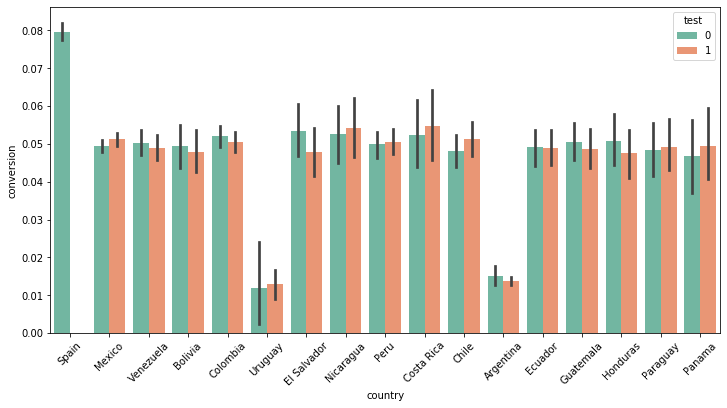

In [27]:
# check the conversion rate in different countries
plt.figure(figsize=(12,6))
sns.barplot(x=data['country'],y=data['conversion'], hue=data['test'], palette='Set2')
plt.xticks(rotation=45)
plt.show()

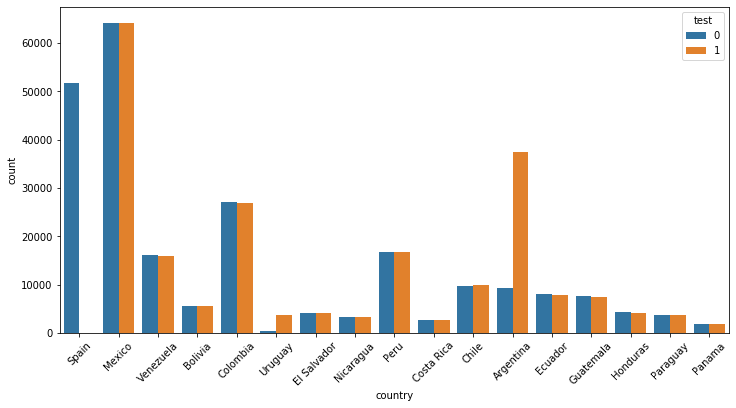

In [113]:
# check the number of users in different countries
plt.figure(figsize=(12,6))
sns.countplot(x=data['country'], hue=data['test'])
plt.xticks(rotation=45)
plt.show()

* <font size=3>there is no Spain based users in test group, so in order to avoid dilute the results, let's filter out the spain based users

In [178]:
# filter Spain based users
df = data.drop(data[data['country']=='Spain'].index, axis=0)
df.head(2)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico


In [179]:
# create age bucket columns
df['age_bucket'] = pd.cut(df['age'], bins=[-1,17,20,25,30,35,40,45,50,55,60,65,70,200],
                          labels = ['0-17','18-20','21-25','26-30','31-35','36-40','41-45',
                                    '46-50','51-55','56-60','61-65','66-70','70+'])

In [31]:
table = df.groupby('test')['conversion'].value_counts().unstack()
table

conversion,0,1
test,,
0,176362,8949
1,206407,9367


In [66]:
t = df.groupby('test')['conversion'].mean()
diff = (t[0] - t[1]) / t[0] 
diff

0.10106539481615753

<font size=3>1.1 Effect Test

In [67]:
## Chi-sqaured test
from statsmodels.stats.proportion import proportions_chisquare
stat, pvalue, table_expected = proportions_chisquare(count=table.loc[:,1],nobs=table.loc[:,0])
print('diff:',diff,'\npvalue:', pvalue)

diff: 0.10106539481615753 
pvalue: 9.5283762199243e-15


In [38]:
## z test
from statsmodels.stats.proportion import proportions_ztest
zstat, pvalue = proportions_ztest(count=table.loc[:,1],nobs=table.loc[:,0])
pvalue

9.528376219924924e-15

<font size=3>1.2 sign test

In [70]:
t_sign = df.groupby(['date','test']).conversion.mean().to_frame()
t_sign = pd.merge(t_sign.xs(1,level=1),t_sign.xs(0,level=1), left_index=True, right_index=True)
t_sign

,conversion_x,conversion_y
date,,
2015-11-30,0.043878,0.051204
2015-12-01,0.041371,0.046249
2015-12-02,0.044216,0.048472
2015-12-03,0.043898,0.049255
2015-12-04,0.043459,0.047085


In [77]:
## double check with sign test
from statsmodels.stats.descriptivestats import sign_test
m, pvalue = sign_test(t_sign['conversion_x'],t_sign['conversion_y'])
pvalue/2

0.03125

In [78]:
## double check with sign test
pvalue = stats.binom.cdf(0, 5, 0.5)
pvalue

0.03125

<font size=4>there is a statistically difference in conversion rate between control and test groups. And the test group's conversion rate is statistically drop 10% compared to the control group

---

<font size=4>Question 2: Explain why that might be happening. Are the localized translations really worse?

<font size=3>2.1 Sanity check

* The user distribution in different segments should be comparable between two groups

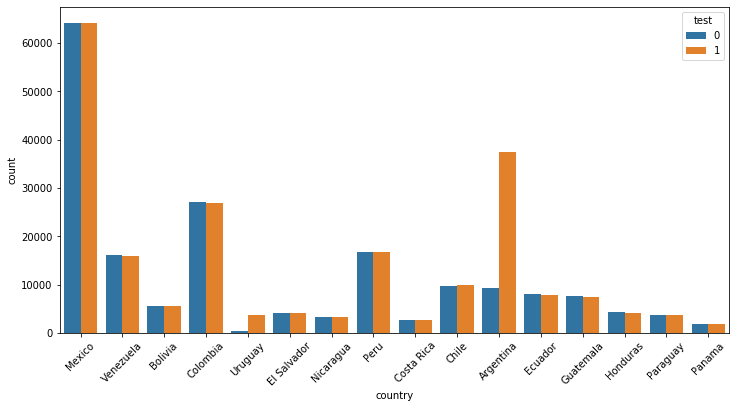

In [87]:
# check the number of users in different countries
plt.figure(figsize=(12,6))
sns.countplot(x=df['country'], hue=df['test'])
plt.xticks(rotation=45)
plt.show()

In [89]:
## Chi-sqaured test
from scipy.stats import chi2_contingency, chi2
t_country = df.groupby(['test','country']).size().unstack()
stat, pvalue, dof, ex = chi2_contingency(t_country, correction=False)
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat)>= critical:
    print('Users are not comparable between test and control groups')
else:
    print('Users are comparable between test and control groups')

Users are not comparable between test and control groups


### From the above results, we can see that Users are not comparable in different countries between test and control groups, and there are much more users in countries 'Argentina' and 'Uruguay' in test group than in control group.

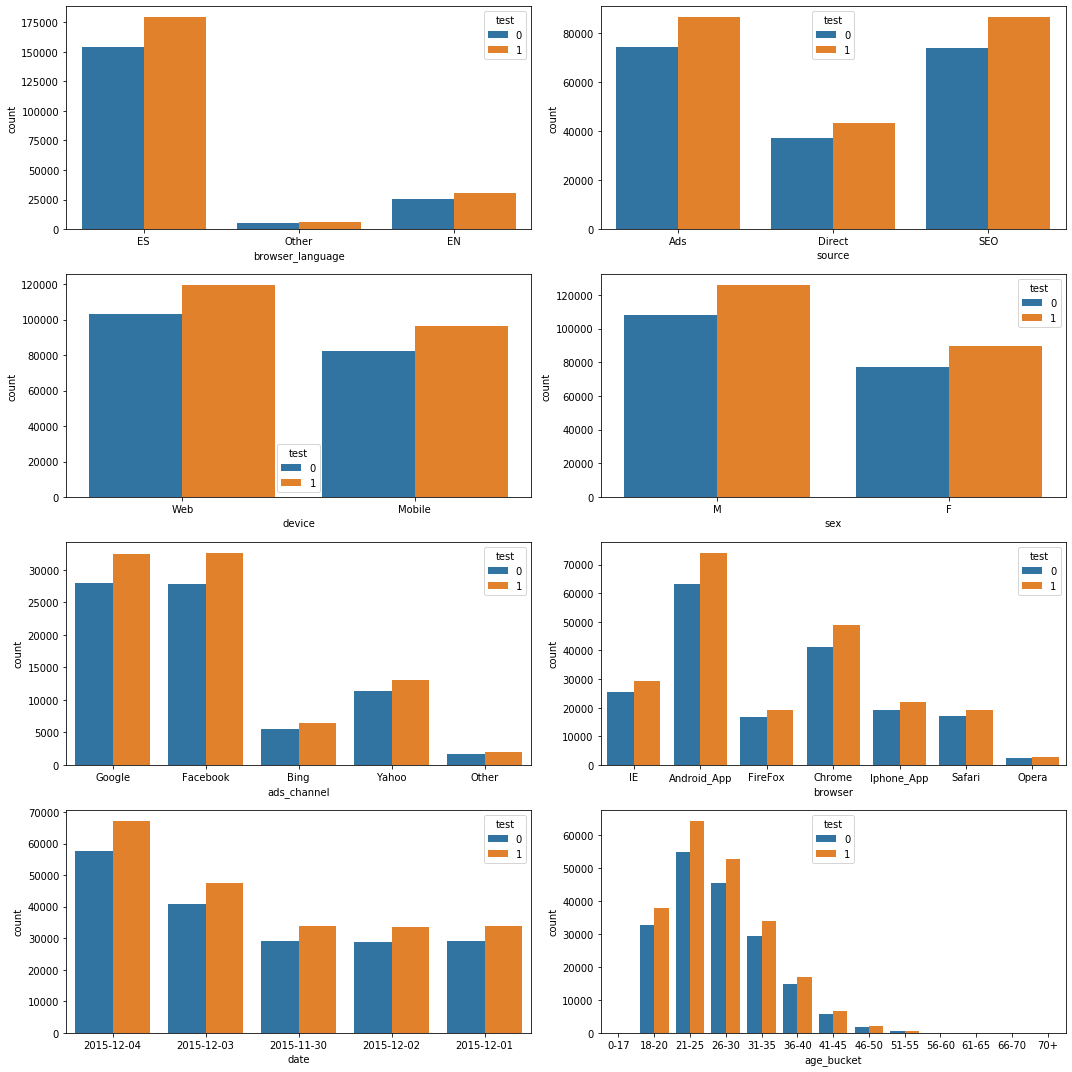

In [130]:
# check user distribution in different segments
fig, ax = plt.subplots(4,2,figsize=(15,15))
sns.countplot(df['browser_language'],hue=df['test'],ax = ax[0][0])
sns.countplot(df['source'],hue=df['test'],ax = ax[0][1])
sns.countplot(df['device'],hue=df['test'],ax = ax[1][0])
sns.countplot(df['sex'],hue=df['test'],ax = ax[1][1])
sns.countplot(df['ads_channel'],hue=df['test'],ax=ax[2][0])
sns.countplot(df['browser'],hue=df['test'],ax=ax[2][1])
sns.countplot(df['date'],hue=df['test'], order=df['date'], ax=ax[3][0])
sns.countplot(df['age_bucket'],hue=df['test'],ax=ax[3][1])

plt.tight_layout()

In [131]:
colnames = ['date','source','device','browser_language','ads_channel','browser','sex','age_bucket']
print('{0:20s} {1:>10s}'.format('Segments','P-Value'))
print('-' * 30)
for col in colnames:
    table = df.groupby(['test', col]).size().unstack()
    stat,pvalue,dof,ex=chi2_contingency(table, correction=False)
    print('{0:20s} {1:10f}'.format(col, pvalue))

Segments                P-Value
------------------------------
date                   0.974552
source                 0.338705
device                 0.277801
browser_language       0.556002
ads_channel            0.654734
browser                0.022098
sex                    0.679235
age_bucket             0.669531


- <font size=3> From the above results, we can see:
    - Users are not comparable in browser and country segments between two groups
    - Users are comparabel in any other segments betwee two groups

<font size=3>2.2 Do effect test in different segments

In [115]:
## test the conversion rate significance for each country
print('{0:15s} {1:>10s}'.format('Country','P-Value'))
print('-' * 30)
for col in df.country.unique():
    table = df[df['country']==col].groupby('test').conversion.value_counts().unstack()
    stat, pvalue, table_expected = proportions_chisquare(count=table.loc[:,1],nobs=table.loc[:,0])
    print('{0:15s} {1:10f}'.format(col, pvalue))

Country            P-Value
------------------------------
Mexico            0.143680
Venezuela         0.553328
Bolivia           0.704763
Colombia          0.398390
Uruguay           0.881297
El Salvador       0.223139
Nicaragua         0.767902
Peru              0.759908
Costa Rica        0.670661
Chile             0.277601
Argentina         0.314689
Ecuador           0.959471
Guatemala         0.551688
Honduras          0.448416
Paraguay          0.877592
Panama            0.690761


In [155]:
# filter out the Argentina and Uruguay users, do effect test
df_filter = df[~df['country'].isin(['Argentina','Uruguay'])]

table = df_filter.groupby('test').conversion.value_counts().unstack()
stat, pvalue, table_expected = proportions_chisquare(count=table.loc[:,1],nobs=table.loc[:,0])
diff= df_filter[df_filter['test']==1].conversion.mean() - df_filter[df_filter['test']==0].conversion.mean()
print('diff:',diff,'\npvalue:',pvalue)

diff: 0.00026464508755583843 
pvalue: 0.7055416673717183


<font size=4>After filter out the Argentina and Uruguay users, we can see the conversion rate is slightly increased in test group, but the result is not significant. 
    - So we can assume that the previous drop in conversion rate may  due to the wrong randomization between test and control groups
    - Also, the users are not randomly splitted in different browsers, we may also need to check that issue with engineers

---

<font size=4>3. Check the experiment duration

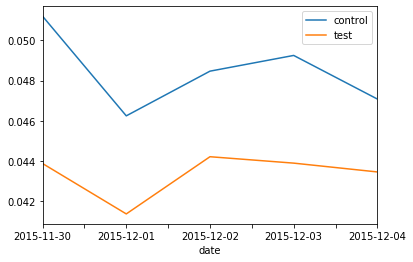

In [180]:
df[df['test']==0].groupby('date').conversion.mean().plot()
df[df['test']==1].groupby('date').conversion.mean().plot()
plt.xticks()
plt.legend(['control','test'])
plt.show()

In [181]:
df['date'] = pd.to_datetime(df['date'])
duration = df.date.max() - df.date.min()
print('The experiment runs:', duration.days,'days')

The experiment runs: 4 days


### The most likely reason for weird A/B test results are:

1) We didn’t collect enough data

2) Some bias has been introduced in the experiment so that test/control people are not really random

Also, from above charts, we can see that: There are much more users at 2015-12-04 than other 3 days, which may indicate that users tend to entry the site after the learning effect.

---

<font size=4>4. Conclusions and Suggestions

### From the plot, we notice a couple of things:


1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up


2. As a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better

### At this point, the next steps would be:


* Acknowledge that there was a bug, go talk to the software engineer in charge of randomization, figure out what went wrong, fix it and re-run the test. Note that when you find a bug, it might be a sign that more things are messed up, not just the one you found. So when you find a bug, always try to get to the bottom of it


* If you do find out that everything else was fine, but for some reason there was only a problem with those two countries, you can potentially adjust the weights for those two segments so that relative frequencies become the same and then re-check the test results